# INDICE

- <a href='#1'>1. Introducción - Análisis de la evolución del COVID en México </a>
- <a href='#2'>2. Lectura de datos y descripción del dataset a utilizar</a>
- <a href='#3'>3. Preprocesamiento, limpieza y creación de nuevas variables </a>
- <a href='#4'>4. Análisis descriptivo de las varibales  </a>
- <a href='#5'>5. Inferencias</a>




In [92]:
#Importarmos las librerias a utilizar
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math
import seaborn as sns
import plotly.graph_objects as go
from zipfile import ZipFile
from io import StringIO
import urllib.request as urllib2
from urllib.request import urlopen   
pd.set_option('max_colwidth',500)
import plotly.graph_objects as go
from collections import Counter
import plotly.offline as py#visualization

In [93]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" 
value="Haz click aquí para desplegar u ocultar el código"></form>''')

# <a id='1'> 1. Introducción - Análisis de la evolución del COVID en México </a>



Nuestro objetivo es hacer inferencias estadisticas sobre datos clínicos de pacientes COVID en México. Antes de empezar con los datos que proporciona de forma abierta el gobierno mexicano vamos a hacer un pequeño analisis de la evolución de los datos del Covid en Mexico a partir de la información de la universidad Johns Hopkins University, para entender un poco mejor los datos que veremos a continuación.

In [94]:
#PREPARACION DE DATOS PARA GRÁFICOS POSTERIORES

#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)

data_jh = data_jh.dropna()
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")
data_jh["Casos"] = pd.to_numeric(data_jh["Casos"])
data_jh["Fallecidos"] = pd.to_numeric(data_jh["Fallecidos"])
data_jh["Recuperados"] = pd.to_numeric(data_jh["Recuperados"])
data_jh["Country/Region"] = data_jh["Country/Region"].astype(str)

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)


data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()
data_sem_jh = data_sem_jh.reset_index()
data_jh = data_jh[data_jh["Country/Region"] == "Mexico"]
data_sem_jh = data_sem_jh[data_sem_jh["Country/Region"] == "Mexico"]

data_sem_jh = data_sem_jh.set_index('Fecha')
data_jh = data_jh.dropna()
data_sem_jh = data_sem_jh.dropna()


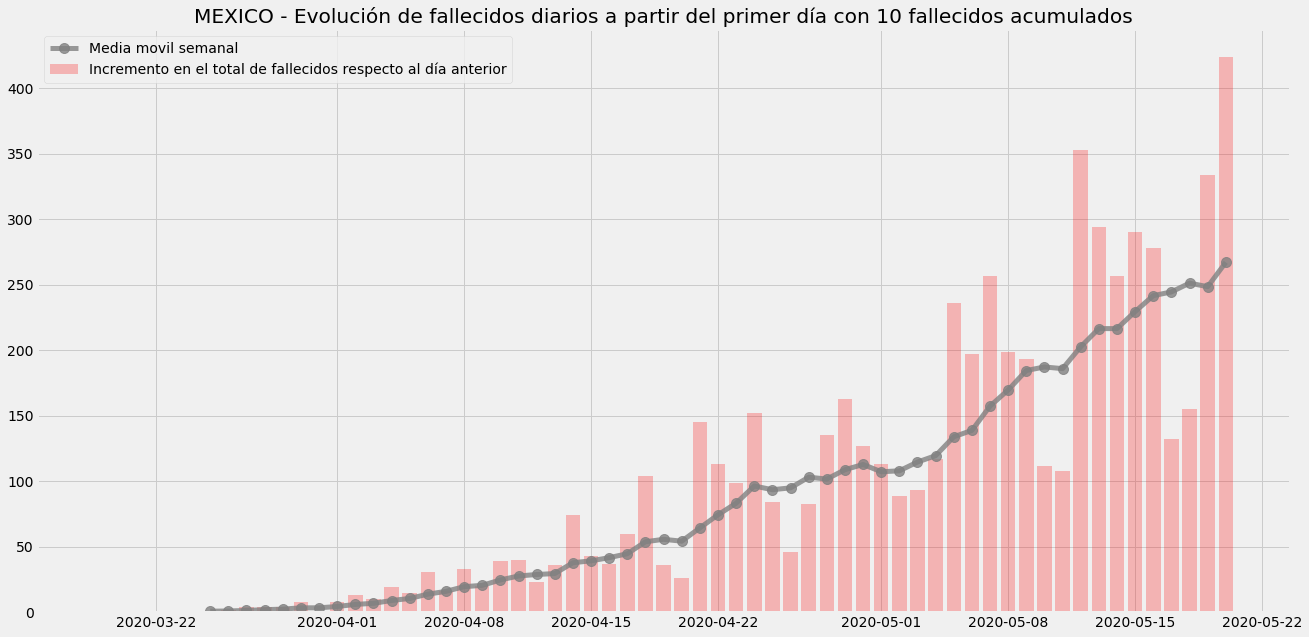

In [95]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem_jh['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_jh.index, data_jh[data_jh["Country/Region"] == "Mexico"]["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('MEXICO - Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend();


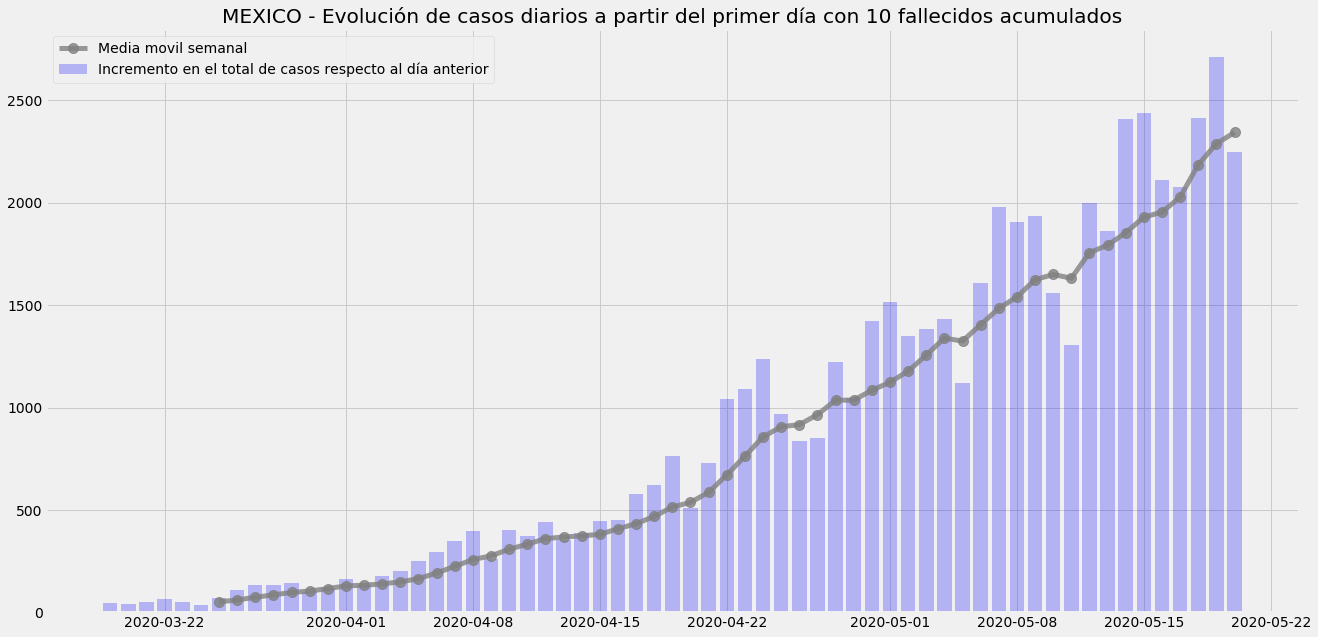

In [96]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem_jh['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_jh.index, data_jh["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('MEXICO - Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend();

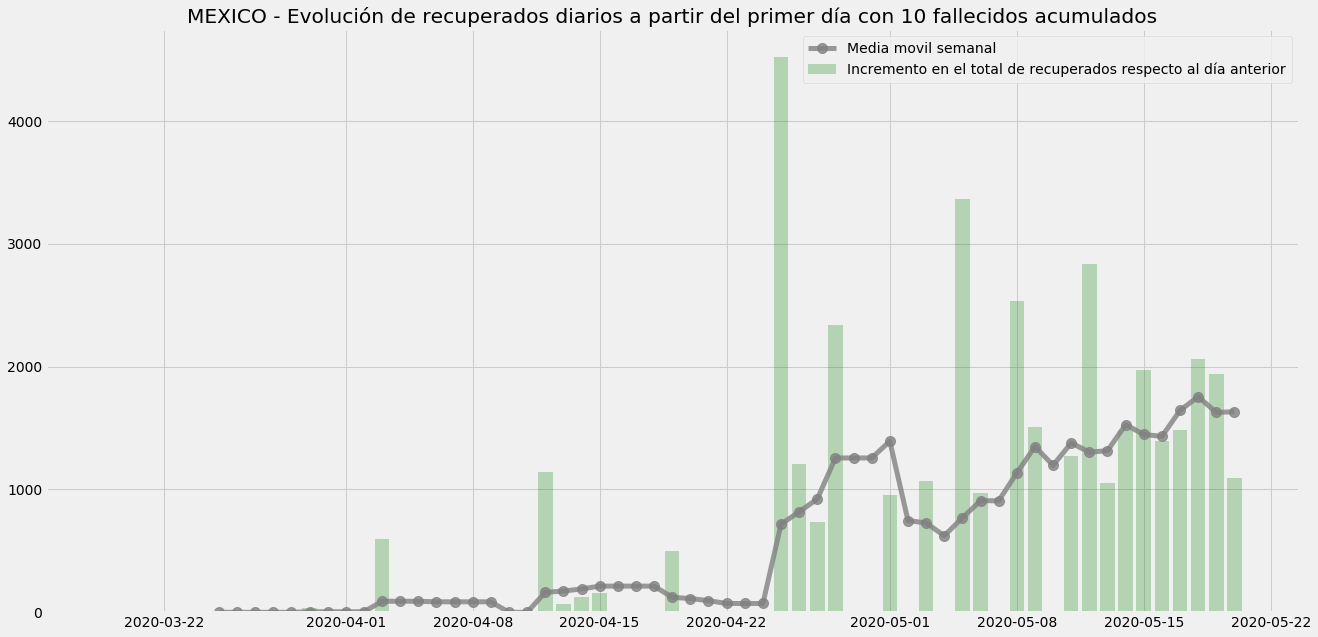

In [97]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem_jh['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_jh.index, data_jh["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('MEXICO - Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend();

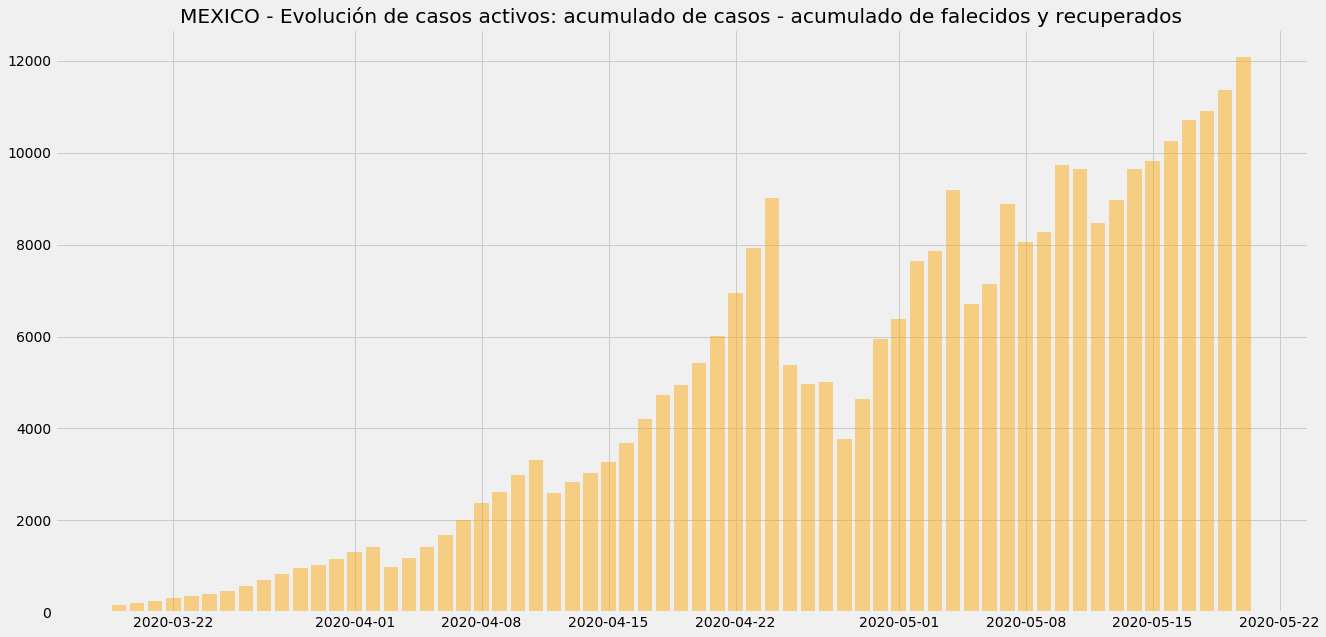

In [98]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the bar chat part of the plot
ax2.bar(data_jh.index, data_jh["Casos"] - data_jh["Fallecidos"] - data_jh["Recuperados"],
        width=0.8, alpha=0.45, color='orange')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('MEXICO - Evolución de casos activos: acumulado de casos - acumulado de falecidos y recuperados');

En el momento en el que se redacta este informe se observa que la epidemia en México está en expansión, la media movil semanal de fallecidos y de nuevos casos, así como el número de casos activos indica que la tendencia es ascendente. Una vez hecha esta pequeña introducción al problema, vamos a empezar a preparar los datos que posteriormente analizaremos sobre el COVID en Mexico.

# <a id='2'> 2. Lectura de datos y descripción del dataset a utilizar  </a>



En primer lugar vamos a leer los datos que vamos a utilizar, la lectura del dataset principal se deja automatizada de la web para que siempre que ejecutemos el notebook tengamos los últimos datos

In [99]:
#Leemos los datos sobre los casos asociados a COVID-19 en México de la web
# https://www.gob.mx/salud/documentos/datos-abiertos-152127
# Por último escribimos el resultado en la capeta resources para que esté disponible en GitHub
# De esta forma cada vez que ejecutemos el notebook tendremos los datos más actualizados
data = pd.read_csv('http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip',encoding = 'ANSI')   # pandas version 0.18.1 takes zip files       
data.to_csv('resources/datos_abiertos_covid19.csv')
#Leemos el diccionario de datos que nos ayudará a entender los datos con los que estamos trabajando
data_dict = pd.read_excel('resources/diccionario_datos_covid19/Descriptores_0419.xlsx')

Una vez leidos los datos vamos a hacer un primer analisis descriptivo y ayudandonos del diccionario de datos que provee el Gobierno mexicano vamos a entender los datos con los que estamos trabajando

In [100]:
#Mostramos las primeras lineas del fichero
data.head(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-05-20,0e345e,2,4,30,1,30,30,193,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
1,2020-05-20,01ee81,2,4,9,2,9,9,5,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
2,2020-05-20,14d52a,2,4,19,2,19,19,46,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
3,2020-05-20,13c967,2,4,23,1,9,23,5,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
4,2020-05-20,041958,2,4,2,2,10,2,4,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97


In [101]:
#Describimos los datos
data.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI
count,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,...,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000,193589.000000
mean,1.637040,9.633254,14.679284,1.511062,16.011612,14.961072,35.900748,1.250102,73.236573,1.827743,...,2.207641,2.503562,2.357252,2.223582,2.350309,2.285187,33.187531,1.872265,98.568044,73.235323
std,0.480855,7.883420,7.957203,0.499879,10.954795,7.867936,46.500860,0.433073,41.167508,0.731724,...,6.037482,7.201848,6.065829,6.114770,5.974930,6.015905,45.683314,0.663802,6.470298,41.170282
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,9.000000,1.000000,9.000000,9.000000,7.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,99.000000,97.000000
50%,2.000000,12.000000,14.000000,2.000000,15.000000,15.000000,20.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000
75%,2.000000,12.000000,20.000000,2.000000,21.000000,20.000000,46.000000,2.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,99.000000,97.000000
max,2.000000,99.000000,32.000000,2.000000,99.000000,32.000000,999.000000,2.000000,99.000000,99.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000,99.000000


Vemos que tenemos 28 columnas y 169 067 registros (en el momento de esta ejecución). Para entender qué significa cada columna vamos a mostrar el diccionario de datos

In [102]:
data_dict

,Nº,NOMBRE DE VARIABLE,DESCRIPCIÓN DE VARIABLE,FORMATO O FUENTE
0,1,FECHA_ACTUALIZACION,"La base de datos se alimenta diariamente, esta variable permite identificar la fecha de la ultima actualizacion.",AAAA-MM-DD
1,2,ID_REGISTRO,Número identificador del caso,TEXTO
2,3,ORIGEN,"La vigilancia centinela se realiza a través del sistema de unidades de salud monitoras de enfermedades respiratorias (USMER). Las USMER incluyen unidades médicas del primer, segundo o tercer nivel de atención y también participan como USMER las unidades de tercer nivel que por sus características contribuyen a ampliar el panorama de información epidemiológica, entre ellas las que cuenten con especialidad de neumología, infectología o pediatría. (Categorías en Catalógo Anexo).",CATÁLOGO: ORIGEN
3,4,SECTOR,Identifica el tipo de institución del Sistema Nacional de Salud que brindó la atención.,CATÁLOGO: SECTOR
4,5,ENTIDAD_UM,Identifica la entidad donde se ubica la unidad medica que brindó la atención.,CATALÓGO: ENTIDADES
5,6,SEXO,Identifica al sexo del paciente.,CATÁLOGO: SEXO
6,7,ENTIDAD_NAC,Identifica la entidad de nacimiento del paciente.,CATALÓGO: ENTIDADES
7,8,ENTIDAD_RES,Identifica la entidad de residencia del paciente.,CATALÓGO: ENTIDADES
8,9,MUNICIPIO_RES,Identifica el municipio de residencia del paciente.,CATALÓGO: MUNICIPIOS
9,10,TIPO_PACIENTE,Identifica el tipo de atención que recibió el paciente en la unidad. Se denomina como ambulatorio si regresó a su casa o se denomina como hospitalizado si fue ingresado a hospitalización.,CATÁLOGO: TIPO_PACIENTE


Observamos que lo que tiene el dataset es un conjunto de pacientes a los que se les ha realizado el test de la COVID19 desde que empezó la pandemia, pero no todos los individuos del dataset son positivos, el campo RESULTADO nos idica si es un paciente COVID o no. En el dataset tenemos unas cuantas fechas (ingreso, sintomas, defunción...), a continuación tenemos una serie de indicadores clínicos (diabetes, epoc, asma, hipertensión...), finalmente datos sobre la nacionalidad e ingreso en UCI.

Como nuestro objetivo es hacer un analisis sobre datos COVID, lo primero que vamos a hacer es filtrar el conjunto de datos por los que tengan un RESULTADO Positivo para SARS-CoV-2, es decir, según el diccionario de datos RESULTADO = 1

In [103]:
#Nos quedamos sólo con los pacientes COVID positivos
data = data[data["RESULTADO"] == 1]

In [104]:
data

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-05-20,0e345e,2,4,30,1,30,30,193,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
1,2020-05-20,01ee81,2,4,9,2,9,9,5,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
2,2020-05-20,14d52a,2,4,19,2,19,19,46,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
3,2020-05-20,13c967,2,4,23,1,9,23,5,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
4,2020-05-20,041958,2,4,2,2,10,2,4,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56589,2020-05-20,07c86c,1,12,17,2,17,17,7,2,...,2,2,2,2,2,1,99,MÃ©xico,99,2
56590,2020-05-20,112158,1,4,30,1,30,30,39,1,...,2,1,2,2,99,1,99,MÃ©xico,99,97
56591,2020-05-20,1c52be,2,12,25,2,25,25,12,1,...,2,2,2,2,2,1,99,MÃ©xico,99,97
56592,2020-05-20,02ad88,1,4,15,1,15,15,106,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97


Nos quedamos con 47144 observaciones, ya que ese es el número de pacientes que han dado positivo para COVID. Ahora vamos a tratar los datos para dejarlos preparados para el analisis. Como nuestro analisis se va a centrar en hacer inferencias sobre caracteristicas clínicas de los pacientes, vamos a eliminar algunas columnas que no utilizaremos como FECHA_ACTUALIZACION, sectores de salud y municipios o la nacionalidad.

In [105]:
#Estas son las columnas que tenemos en este momento en el DF
data.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')

In [106]:
#Eliminamos las columnas que no vamos a utilizar
data = data.drop(['FECHA_ACTUALIZACION', 'ORIGEN','SECTOR','ENTIDAD_UM','ENTIDAD_NAC','ENTIDAD_RES','MUNICIPIO_RES',
                 'PAIS_NACIONALIDAD','MIGRANTE','PAIS_ORIGEN'], axis=1)


In [107]:
#Estas son las columnas con las que nos quedamos en nuestro Df
data.columns

Index(['ID_REGISTRO', 'SEXO', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO',
       'UCI'],
      dtype='object')

# <a id='3'> 3. Preprocesamiento, limpieza y creación de nuevas variables </a>

La unica forma de identificar si el paciente ha fellecido por COVID es viendo si su fecha de fallecimiento es menor que 9999-99-99, por lo tanto vamos a crearnos una nueva columna Sí/NO con la misma lógica que utilizan en todo el dataset que es 1 = SÍ, 2= NO

In [108]:
#Creamos una nueva columna binaria sobre fallecidos
data.loc[data['FECHA_DEF'] == "9999-99-99", 'Fallecido'] = int(2)
data.loc[data['FECHA_DEF'] != "9999-99-99", 'Fallecido'] = int(1)

In [109]:
print( "Número de casos Covid en Mexico :" , data['Fallecido'].count() )
print( "Número de fallecidos por Covid en Mexico :" , data[data['Fallecido'] == 1]["Fallecido"].count())

Número de casos Covid en Mexico : 56594
Número de fallecidos por Covid en Mexico : 6090


Vamos ahora a limpiar el dataset y a estandarizar las variables. *Recordamos que 1 = SÍ, 2= NO*

In [110]:
data.describe()

,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,DIABETES,EPOC,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,UCI,Fallecido
count,56594.000000,56594.000000,56594.00000,56594.000000,56594.000000,56594.000000,56594.000000,56594.000000,56594.000000,56594.000000,...,56594.000000,56594.000000,56594.000000,56594.000000,56594.000000,56594.000000,56594.000000,56594.0,56594.000000,56594.000000
mean,1.574990,1.380023,60.87716,1.715871,46.600505,1.005495,56.833180,4.364791,2.482207,2.633353,...,2.439782,2.799908,2.653762,2.528166,2.657685,2.599569,40.057215,1.0,60.880023,1.892391
std,0.494349,0.485396,46.15749,0.734402,15.877520,0.073927,46.939707,15.006232,7.986629,7.904379,...,7.929724,8.917148,8.056096,8.402658,8.065740,8.084051,47.661168,0.0,46.155627,0.309888
min,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
25%,1.000000,1.000000,2.00000,1.000000,35.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.0,2.000000,2.000000
50%,2.000000,1.000000,97.00000,2.000000,46.000000,1.000000,97.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0,97.000000,2.000000
75%,2.000000,2.000000,97.00000,2.000000,57.000000,1.000000,97.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,1.0,97.000000,2.000000
max,2.000000,2.000000,99.00000,99.000000,114.000000,2.000000,98.000000,99.000000,98.000000,98.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,1.0,99.000000,2.000000


In [111]:
#Comprobamos si tiene nulos el dataset
data.isnull().sum()

ID_REGISTRO           0
SEXO                  0
TIPO_PACIENTE         0
FECHA_INGRESO         0
FECHA_SINTOMAS        0
FECHA_DEF             0
INTUBADO              0
NEUMONIA              0
EDAD                  0
NACIONALIDAD          0
EMBARAZO              0
HABLA_LENGUA_INDIG    0
DIABETES              0
EPOC                  0
ASMA                  0
INMUSUPR              0
HIPERTENSION          0
OTRA_COM              0
CARDIOVASCULAR        0
OBESIDAD              0
RENAL_CRONICA         0
TABAQUISMO            0
OTRO_CASO             0
RESULTADO             0
UCI                   0
Fallecido             0
dtype: int64

In [112]:
#Comprobamos si tiene valores perdidos el dataset
data.isna().sum()

ID_REGISTRO           0
SEXO                  0
TIPO_PACIENTE         0
FECHA_INGRESO         0
FECHA_SINTOMAS        0
FECHA_DEF             0
INTUBADO              0
NEUMONIA              0
EDAD                  0
NACIONALIDAD          0
EMBARAZO              0
HABLA_LENGUA_INDIG    0
DIABETES              0
EPOC                  0
ASMA                  0
INMUSUPR              0
HIPERTENSION          0
OTRA_COM              0
CARDIOVASCULAR        0
OBESIDAD              0
RENAL_CRONICA         0
TABAQUISMO            0
OTRO_CASO             0
RESULTADO             0
UCI                   0
Fallecido             0
dtype: int64

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Importante:</strong>
Observamos que no hay valores nulos ni perdidos, pero del describe apreciamos que para algunas variables binarias como intubado, neumonia... el valor máximo es 99, también vemos que aparece el valor 97. ¿Qué significa esto? Según el catalogo de datos 97 = NO APLICA, 98 = SE IGNORA, 99 = NO ESPECIFICADO. Por lo tanto si tenemos valores ausentes encubiertos imputados con otro número.

</div>



In [113]:
data[data.UCI == 97]

,ID_REGISTRO,SEXO,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,UCI,Fallecido
0,0e345e,1,1,2020-04-15,2020-04-12,9999-99-99,97,2,38,1,...,2,2,2,2,2,2,99,1,97,2.0
1,01ee81,2,1,2020-04-13,2020-04-04,9999-99-99,97,2,29,1,...,2,2,2,2,2,2,99,1,97,2.0
2,14d52a,2,1,2020-04-22,2020-04-15,9999-99-99,97,2,70,1,...,2,2,2,2,2,2,99,1,97,2.0
3,13c967,1,1,2020-04-20,2020-04-10,9999-99-99,97,2,49,1,...,2,2,2,2,2,2,99,1,97,2.0
4,041958,2,1,2020-04-28,2020-04-23,9999-99-99,97,2,64,1,...,2,2,2,2,2,2,99,1,97,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56587,144d5e,2,1,2020-05-06,2020-04-24,9999-99-99,97,2,55,1,...,2,2,2,2,2,2,99,1,97,2.0
56590,112158,1,1,2020-05-07,2020-05-04,9999-99-99,97,2,41,1,...,2,2,2,1,2,2,99,1,97,2.0
56591,1c52be,2,1,2020-05-07,2020-05-03,9999-99-99,97,2,46,1,...,1,2,2,2,2,2,2,1,97,2.0
56592,02ad88,1,1,2020-05-07,2020-05-06,9999-99-99,97,2,29,1,...,2,1,2,2,2,2,99,1,97,2.0


In [114]:
#Vamos a analizar en primer lugar los campos que vienen con valor 97
data[data == 97].count()

ID_REGISTRO               0
SEXO                      0
TIPO_PACIENTE             0
FECHA_INGRESO             0
FECHA_SINTOMAS            0
FECHA_DEF                 0
INTUBADO              35087
NEUMONIA                  0
EDAD                     10
NACIONALIDAD              0
EMBARAZO              32541
HABLA_LENGUA_INDIG        0
DIABETES                  0
EPOC                      0
ASMA                      0
INMUSUPR                  0
HIPERTENSION              0
OTRA_COM                  0
CARDIOVASCULAR            0
OBESIDAD                  0
RENAL_CRONICA             0
TABAQUISMO                0
OTRO_CASO                 0
RESULTADO                 0
UCI                   35087
Fallecido                 0
dtype: int64

Vemos que hay valor 97 en los campos INTUBADO y UCI, estos dos valores coinciden y se le asignan cuando el paciente es ambulatorio, por lo tanto los vamos a cambiar por NO es decir 2. En el caso de embarazos, cuando son hombres, imputan el valor con NO APLICA, como es lógico, pero por mantener la homogeneidad lo imputaremos con no. En el caso de la edad son valores correctos.

In [115]:
data.loc[data['INTUBADO'] == 97, 'INTUBADO'] = int(2)
data.loc[data['UCI'] == 97, 'UCI'] = int(2)
data.loc[data['EMBARAZO'] == 97, 'EMBARAZO'] = int(2)


Ahora vamos a analizar el caso en el que aparece el valor 98 que significa que se ignora. Como vemos a continuación son pocos los registros con este valor y como son valores ausentes los vamos a eliminar.

In [116]:
data[data == 98].count()


ID_REGISTRO             0
SEXO                    0
TIPO_PACIENTE           0
FECHA_INGRESO           0
FECHA_SINTOMAS          0
FECHA_DEF               0
INTUBADO                0
NEUMONIA                0
EDAD                    4
NACIONALIDAD            0
EMBARAZO              127
HABLA_LENGUA_INDIG      0
DIABETES              392
EPOC                  386
ASMA                  397
INMUSUPR              403
HIPERTENSION          386
OTRA_COM              492
CARDIOVASCULAR        401
OBESIDAD              434
RENAL_CRONICA         402
TABAQUISMO            403
OTRO_CASO               0
RESULTADO               0
UCI                     0
Fallecido               0
dtype: int64

In [117]:
#Eliminamos los valores ausentes mirando las columnas en las que aparecen
data = data[data.DIABETES != 98]
data = data[data.EMBARAZO != 98]
data = data[data.EPOC != 98]
data = data[data.ASMA != 98]
data = data[data.INMUSUPR != 98]
data = data[data.HIPERTENSION != 98]
data = data[data.OTRA_COM != 98]
data = data[data.CARDIOVASCULAR != 98]
data = data[data.OBESIDAD != 98]
data = data[data.RENAL_CRONICA != 98]
data = data[data.TABAQUISMO != 98]


In [118]:
data[data == 98].count()


ID_REGISTRO           0
SEXO                  0
TIPO_PACIENTE         0
FECHA_INGRESO         0
FECHA_SINTOMAS        0
FECHA_DEF             0
INTUBADO              0
NEUMONIA              0
EDAD                  4
NACIONALIDAD          0
EMBARAZO              0
HABLA_LENGUA_INDIG    0
DIABETES              0
EPOC                  0
ASMA                  0
INMUSUPR              0
HIPERTENSION          0
OTRA_COM              0
CARDIOVASCULAR        0
OBESIDAD              0
RENAL_CRONICA         0
TABAQUISMO            0
OTRO_CASO             0
RESULTADO             0
UCI                   0
Fallecido             0
dtype: int64

Por último veremos los casos de valor 99 que significa no especificado. Como vemos a continuación aparece en pocas columnas, eliminaremos los registros en los que aparece pocas veces en la varibale como INTUBADO o NEUMONIA. En los casos que aparece muchas veces HABLA_LENGUA_INDIG y OTRO_CASO (otras enfermedades) vamos a considerar que es NO.

In [119]:
data[data == 99].count()

ID_REGISTRO               0
SEXO                      0
TIPO_PACIENTE             0
FECHA_INGRESO             0
FECHA_SINTOMAS            0
FECHA_DEF                 0
INTUBADO                  9
NEUMONIA                  2
EDAD                      4
NACIONALIDAD              0
EMBARAZO                  0
HABLA_LENGUA_INDIG     1360
DIABETES                  0
EPOC                      0
ASMA                      0
INMUSUPR                  0
HIPERTENSION              0
OTRA_COM                  0
CARDIOVASCULAR            0
OBESIDAD                  0
RENAL_CRONICA             0
TABAQUISMO                0
OTRO_CASO             21972
RESULTADO                 0
UCI                       9
Fallecido                 0
dtype: int64

In [120]:
#Eliminamos los valores ausentes mirando las columnas en las que aparecen
data = data[data.INTUBADO != 99]
data = data[data.NEUMONIA != 99]
data = data[data.UCI != 99]
#Imputamos No en el resto
data.loc[data['HABLA_LENGUA_INDIG'] == 99, 'HABLA_LENGUA_INDIG'] = int(2)
data.loc[data['OTRO_CASO'] == 99, 'OTRO_CASO'] = int(2)

In [121]:
#Guardamos el dataset resultante de la limpieza
data.to_csv('resources/datos_covid19_mexico_limpios.csv')


Vamos a comprobar que lo hemos hecho bien, todas las variables que no son fechas o la edad, son binarias, por lo que sólo deberian tomar dos valores.

In [122]:
print ("\nUnique values :  \n",data.nunique())


Unique values :  
 ID_REGISTRO           55775
SEXO                      2
TIPO_PACIENTE             2
FECHA_INGRESO            84
FECHA_SINTOMAS           95
FECHA_DEF                63
INTUBADO                  2
NEUMONIA                  2
EDAD                    106
NACIONALIDAD              2
EMBARAZO                  2
HABLA_LENGUA_INDIG        2
DIABETES                  2
EPOC                      2
ASMA                      2
INMUSUPR                  2
HIPERTENSION              2
OTRA_COM                  2
CARDIOVASCULAR            2
OBESIDAD                  2
RENAL_CRONICA             2
TABAQUISMO                2
OTRO_CASO                 2
RESULTADO                 1
UCI                       2
Fallecido                 2
dtype: int64


Vamos a crear ahora dos variables categoricas: el sexo en texto y la edad por rangos.

In [123]:
#Variable categorica edad
data.loc[(data['EDAD'] >= 0) & (data['EDAD'] < 10), 'EDAD_CAT'] = '0-Entre 0 y 10 años'
data.loc[(data['EDAD'] >= 10) & (data['EDAD'] < 20), 'EDAD_CAT'] = '1-Entre 10 y 20 años'
data.loc[(data['EDAD'] >= 20) & (data['EDAD'] < 30), 'EDAD_CAT'] = '2-Entre 20 y 30 años'
data.loc[(data['EDAD'] >= 30) & (data['EDAD'] < 40), 'EDAD_CAT'] = '3-Entre 30 y 40 años'
data.loc[(data['EDAD'] >= 40) & (data['EDAD'] < 50), 'EDAD_CAT'] = '4-Entre 40 y 50 años'
data.loc[(data['EDAD'] >= 50) & (data['EDAD'] < 60), 'EDAD_CAT'] = '5-Entre 50 y 60 años'
data.loc[(data['EDAD'] >= 60) & (data['EDAD'] < 70), 'EDAD_CAT'] = '6-Entre 60 y 70 años'
data.loc[(data['EDAD'] >= 70) & (data['EDAD'] < 80), 'EDAD_CAT'] = '7-Entre 70 y 80 años'
data.loc[(data['EDAD'] >= 80) & (data['EDAD'] < 90), 'EDAD_CAT'] = '8-Entre 80 y 90 años'
data.loc[data['EDAD'] >= 90, 'EDAD_CAT'] = '9-Mayor de 90 años'

#Variable categorica sexo
data.loc[data['SEXO'] == 1, 'SEXO_CAT'] = 'MUJER'
data.loc[data['SEXO'] == 2, 'SEXO_CAT'] = 'HOMBRE'


# <a id='4'> 4. Análisis descriptivo de las varibales </a>



En primer lugar vamos a hacer una tabla resumen de todos los datos númericos

In [124]:
Id_col = ["ID_REGISTRO"]
summary = (data[[i for i in data.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

A continuación vamos a hacer una serie de gráficos para analizar la distribución de las variables.

In [125]:

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data[data['Fallecido'] == 1]["Fallecido"] ,
                           x=data[data['Fallecido'] == 1]['EDAD_CAT'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Número de fallecidos por rangos de edad"
)
fig.show()


# <a id='5'> 5. Inferencia estadística sobre 'Fallecido'</a>



In [126]:
# Importación de librerías para este apartado
import scipy.stats as stats
import statistics

## <a id='5.1'> 5.1 Selección de los grupos de datos que se quieren analizar/comparar</a>

En este apartado se va a realizar un análisis estadístico inferencial con los datos del juego que está siendo analizado en esta práctica.

Como se ha visto en la parte de limpieza de los datos, el dataset cuenta con una serie de pacientes a los que se les ha realizado la prueba del coronavirus y han dado positivo en ella, ya que las filas con negativos han sido eliminadas del dataset. Además, se ha creado una variable llamada "Fallecido", que indica con un 1 si el paciente ha fenecido y con un 2 si ha sobrevivido a la enfermedad.

EL objetivo de este análisis es comprender qué variables tienen una mayor influencia sobre la variable "Fallecido", para determinar qué características clínicas suponen factores de riesgo en pacientes con Coronavirus.

En primer lugar, conviene analizar los resultados de la matriz de correlaciones, donde se indica cuál es el grado de correlación entre las diferentes variables. Se observa que, para la variable "Fallecido", existen valores altos de correlación, tanto positiva como negativa.

In [127]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data_list = [trace]
fig = go.Figure(data=data_list,layout=layout)
py.iplot(fig)

Como era de esperar, las variables que indican si el paciente fue intubado o ingresado en la UCI tienen una gran correlación con el fallecimiento de los pacientes, pero, estas variables no pueden ser consideradas factores de riesgo, ya que un paciente que requiera de cuidados como estos ya está en un estado avanzado de la enfermedad.

Por ello, se Reordenan las correlaciones de acuerdo a sus valores más altos, donde se verá en la parte superiro, las variables con correlación negativa más alta, y, en la baja, con correlación positiva más alta.

In [128]:
print(correlation['Fallecido'].sort_values()) # Se ordenan las correlaciones con Fallecido

TIPO_PACIENTE        -0.370391
EDAD                 -0.284115
OTRO_CASO            -0.132554
SEXO                 -0.073237
EMBARAZO             -0.022654
ASMA                 -0.012500
NACIONALIDAD          0.006976
TABAQUISMO            0.015967
OTRA_COM              0.028152
HABLA_LENGUA_INDIG    0.034856
INMUSUPR              0.045276
OBESIDAD              0.054295
CARDIOVASCULAR        0.069148
EPOC                  0.093659
RENAL_CRONICA         0.117043
HIPERTENSION          0.176850
DIABETES              0.183359
UCI                   0.250542
INTUBADO              0.341292
NEUMONIA              0.364604
Fallecido             1.000000
RESULTADO                  NaN
Name: Fallecido, dtype: float64


En cuanto al resto de variables que parecen tener una inflcuencia mayor en el fallecimiento de los pacientes se encuentra 'NEUMONIA', 'DIABETES', 'EDAD', 'HIPERTENSION', 'OTRO_CASO', 'RENAL_CRONICA' y 'EPOC'. 

Esto quiere decir que son  estas variables las que parecen explicar de mejor manera la varianza de la variable Fallecido, y es con ellas con las que se va a realizar el análisis. También se va a guardar la variable 'SEXO', ya que se desea analizar el caso del que se lleva hablando desde el inicio de la pandemia por el cual los hombres son más susceptibles a fallecer que las mujeres por la enferemedad del Coronavirus.

In [129]:
# Se guardan únicamente las variables con alta correlación
data_analisis = data[['Fallecido','NEUMONIA','DIABETES','EDAD','HIPERTENSION','OTRO_CASO','RENAL_CRONICA','EPOC','SEXO']]

## <a id='5.2'> 5.2 Comprobación de la normalidad y homogeneidad de la varianza</a>

La única variable numérica del dataset que se está teniendo en cuenta es la variable EDAD, la cual indica la edad del paciente en el momento en el que se actualizó su registro. Es interesante comprender si esta variable está distribuida normalmente, y si su varianza es similar entre los grupos de Fallecido=1 y Fallecido=2.

En otras palabras, se va a analizar si la variable EDAD se encuentra similarmente distribuida entre las personas que sobreviven y las personas que mueren por Coronavirus, con el objetivo de realizar posteriormente un test que indique si la verdadera media de ambos grupos es o no la misma.

Para ello, se comienza mediante un análisis visual de la distribución de la variable. Para ello, se representan un gráfico de distribución, un gráfico de caja y uno de violín, que permiten, de tres maneras distintas, comprobar cuál es la forma de la distribución de la variable de edad. También es posible conocer la cantidad de outliers que puedan existir.

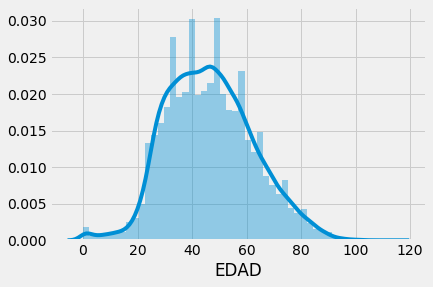

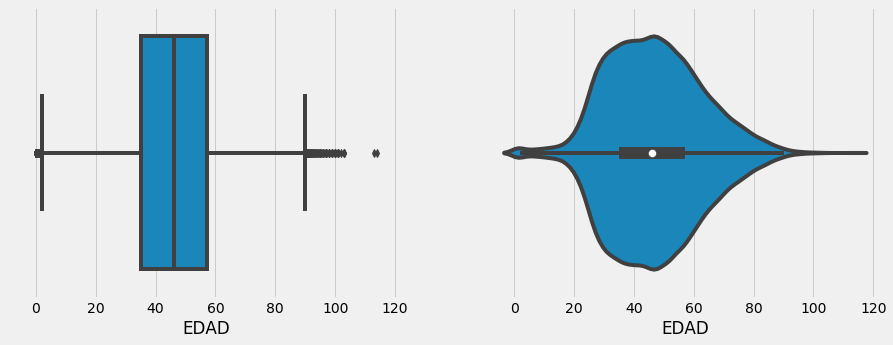

In [130]:
sns.distplot(data_analisis['EDAD'])
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
sns.boxplot(data_analisis['EDAD'], ax=axs[0])
sns.violinplot(data_analisis['EDAD'], ax=axs[1])

Aparentemente, la variable de EDAD se encuentra normalmente distribuida, si analizamos el resultado visualmente. Solamente se aprecia la aparición de grandes picos en la distribución que podrían provocar anormalidades, y se ve que cuenta con algún outlier de edades avanzadas. No obstante, en general, parece bastante normal.

Sin embargo, debe realizarse un test de normalidad que indique si de verdad la distribución de la edad de las personas que dieron positivo en el test de coronavirus es normal.

Para ello se va a realizar un test de Shapiro-Wilk, para el que se definen dos hipótesis, con un nivel de confianza del 95%.
* H<sub>0</sub>: la variable edad pertenece a una población con distribución normal.
* H<sub>1</sub>: la variable edad no pertenece a una población con distribución normal.

In [131]:
W, p_value = stats.shapiro(data_analisis['EDAD'])
print("Saphiro-Wilk p_value", p_value)

Saphiro-Wilk p_value 4.988622532996349e-43


Debido al P valor obtenido en este test, considerablemente más bajo a 0.05, se debe rechazar la hipótesis nula en favor de la alternativa, y se determina que la variable EDAD no pertenece a una distribución normal.

Ahora que se ha identificado que la población a la que pertenece la variable de EDAD no pertenece a una distribución normal, se debe determinar la homogeneidad de las varianzas en dicha distribución. Para ello se comparará la varianza de la distribución de edad para personas no fallecidas por Coronavirus y para aquellas que sí que fallecieron, estableciendo si la varianza de ambas poblaciones a las que pertenecen es la misma.

Para ello, se usará el test de Fligner-Killeen, ya que presenta buenos resultados cuando los datos no se encuentran normalmente distribuidos, para el cual se toman las siguientes hipótesis, con un 95% de confianza:
* H<sub>0</sub>: la varianza de la distribución de edad para las personas fallecidas es la misma que para las personas no fallecidas.
* H<sub>1</sub>: la varianza de la distribución de edad para las personas fallecidas es la distinta que para las personas no fallecidas.

In [132]:
stats.fligner(data_analisis.loc[data_analisis['Fallecido']==1]['EDAD'],
              data_analisis.loc[data_analisis['Fallecido']==2]['EDAD'])

FlignerResult(statistic=52.406243301342435, pvalue=4.512869586965039e-13)

El resultado de este test indica que las distribuciones a las que pertenecen estas variables tienen varianzas diferentes, ya que el P valor obtenido es más bajo a 0.05 y se debe rechazar la hipótesis nula. Con lo cual, el test que se seleccione en el apartado 5.3.1 deberá tener en cuenta que las muestras que se quieren comparar pertenecen a poblaciones no normales de varianzas distintas.

## <a id='5.3'> 5.3 Aplicación de pruebas estadísticas para comparar los grupos de datos</a>

### <a id='5.3.1'> 5.3.2 Test de Welch y ANOVA: ¿es la media de las personas que fallecen por coronavirus diferente a la de las personas que sobreviven? ¿Cuál es la probabilidad de fallecimiento por grupo de edad?</a>

En este apartado se desea determinar, para un nivel de confianza del 95%, cual de las hipótesis que se plantean a continuación es cierta:
* H<sub>0</sub>: la media de edad de las personas que sobreviven y que fallecen ante el Coronavirus es la misma (&mu;(EDAD)<sub>Fallecido=1</sub> = &mu;(EDAD)<sub>Fallecido=2</sub>)
* H<sub>1</sub>: la media de edad de las personas que sobreviven y que fallecen ante el Coronavirus es diferente (&mu;(EDAD)<sub>Fallecido=1</sub> &#8800; &mu;(EDAD)<sub>Fallecido=2</sub>)

Basándose en lo obtenido en el apartado 5.2, las poblaciones a las que pertenecen las distribuciones de edad de las personas que fallecen y las que no, por coronavirus, ni son normales ni tienen la misma varianza. Por lo tanto, dado que sea determinar si las varianzas son o no las mismas, es posible realizar un test de Wilcoxon para muestras no pareadas sobre los distintos grupos. Se dice que no están pareadas, ya que no son medidas posteriores de la misma magnitud, si no muestras de diferentes individuos.

In [133]:
stats.ranksums(data_analisis.loc[data_analisis['Fallecido']==1]['EDAD'],
              data_analisis.loc[data_analisis['Fallecido']==2]['EDAD'])

RanksumsResult(statistic=66.31423593144072, pvalue=0.0)

El resultado obtenido es que la probabilidad de que ambas muestras pertenezcan a la misma población, y, por tanto, tengan la misma media, es extremadamente baja. Por lo tanto debido a que el P valor es inferior a 0.05, se rechaza la hipótesis nula y se afirma que la media de edad de las personas que mueren por Coronavirus es distinta a la de la media de edad de las personas que lo sobreviven.

Para ilustrar este resultado, se va a representar un diagrama de densidad en el que se mostrará la distribución de ambas muestras de edad, separadas por si el paciente murió o no. Debido a los resultados obtenidos en el test, es de esperar que las medias de ambas muestras se encuentren muy separadas, y que las distribuciones no se parezcan.

Edad media de los pacientes fallecidos:  59.61666666666667
Edad media de los pacientes no fallecidos:  44.99101033410254


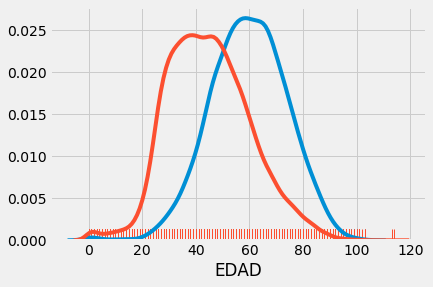

In [134]:

sns.distplot(data_analisis.loc[data_analisis['Fallecido']==1]['EDAD'], hist=False, rug=True)
sns.distplot(data_analisis.loc[data_analisis['Fallecido']==2]['EDAD'], hist=False, rug=True)

print("Edad media de los pacientes fallecidos: ", 
      statistics.mean(data_analisis.loc[data_analisis['Fallecido']==1]['EDAD']))
print("Edad media de los pacientes no fallecidos: ", 
      statistics.mean(data_analisis.loc[data_analisis['Fallecido']==2]['EDAD']))

Se aprecia que lo obtenido en los tests es cierto, ya que mientras que la media de edad de los pacientes fallecidos está en torno a los 60 años, la de los no fallecidos se encuentra en torno a los 45.

Por lo tanto, se puede concluir que la media de edad de los pacientes que mueren por Coronavirus es distinta (y probablemente mayor) que la de aquellos que lo sorbreviven. Por lo tanto, la edad avanzada supone un factor de riesgo frente a la enfermedad.

Para terminar este apartado se va a realizar un análisis ANOVA en el que se compararán las probabilidades de Fallecimiento entre grupos de edad. Para ello, lo primero que se decide es la manera en la que se codifican los grupos para este análisis. Para evitar que los resultados del test aparezcan en lógica negativa, se cambia la codificación de la variable 'Fallecido' a 0 si sobrevivió y 1 si murió.

Después, se dividen los pacientes de la variable 'EDAD' en 4 grupos, en cuartiles, para que mantengan su homogeneidad. De esta manera se obtiene que los grupos en los que se dividirá el análisis son (0.0, 35.0),(35.0, 46.0, (46.0, 57.0) y (57.0, 114.0), todos ellos cerrados por la derecha.

In [135]:
data_anova = pd.DataFrame()
data_anova['Fallecido'] = data_analisis['Fallecido'].apply(lambda x: int(x==1))
data_anova['Grupo_edad'] = pd.qcut(data_analisis['EDAD'], q=4)

Después, se plantean las hipótesis a resolver con el test, que son similares a las que se acaban de resolver anteriormente en este apartado pero de manera separada por categorías, y las hipótesis se plantean con la probabilidad de Fallecido, no sobre las medias de EDAD.
* H<sub>0</sub>: la probabilidad de fallecimiento es la misma entre todos los grupos de edad.
* H<sub>1</sub>: la probabilidad de fallecimiento es distinta entre los diferentes grupos.

Con estas hipótesis se plantea un test ANOVA usando el método ols() de la librería statsmodels. Esto generá una tabla que permitirá obtener el P valor que dará respuesta a las hipótesis planteadas y, además, generará unos coeficientes para cada grupo, que permitirán comparar la probabilidad de fallecimiento contra el grupo de control, que en este caso será el primero de todos, es decir (0.0, 35.0) años de edad.

In [136]:
from statsmodels.formula.api import ols
results = ols('Fallecido ~ Grupo_edad', data=data_anova).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fallecido   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1600.
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        12:05:20   Log-Likelihood:                -11241.
No. Observations:               55775   AIC:                         2.249e+04
Df Residuals:                   55771   BIC:                         2.253e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.0175      0.002      7.184      0.000       0.013       0.022
Grupo_edad[T.Interval(35.0, 46.0, closed='right')]      0.0376      0.003     10.813      0.000       0.031       0.044
Grupo_edad[T.Interval(46.0, 57.0, closed='right')]      0.1010      0.004     28.578      0.000       0.094       0.108
Grupo_edad[T.Interval(57.0, 114.0, closed='right')]     0.2288      0.004     64.984      0.000       0.222       0.236
==============================================================================
Omnibus:                    23516.937   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80652.396
Skew:                           2.235   Prob(JB):                         0.00
Kurtosis:                       6.837   Cond. No.                         4.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Los resultados obtenidos en este test permiten confirmar que se debe rechazar de nuevo la hipótesis nula, ya que el P valor obtenido es muy bajo, de manera que se afirma que existen diferencias entre los distintos grupos de edad en la probabilidad de fallecimiento.

Si se analizan los coefiecientes obtenidos, se obtiene que la probabilidad en el grupo de control (que aparece como Intercept) es muy baja, y llega a multiplicarse hasta por 20 veces en el grupo de edad más avanzada. Por lo tanto, se concluye que la edad de los pacientes es un factor determinante en su riesgo de fallecimiento.

Los resultados de este test pueden ser corroborados si se realiza un countplot de los fallecidos y supervivientes por grupo de edad. En él, se puede apreciar cómo  a pesar de que se reducen el número de casos con la edad, los fallecidos (1) aumentan considerablemente a medida que se avanza en los grupos de edad.

Text(0.5, 1.0, 'Ocurrencias según Grupo_edad y Fallecido')

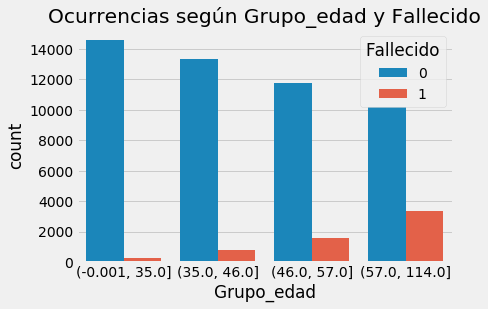

In [137]:
# Se pinta un countplot con los datos de fallecimiento por grupo de edad
fig = sns.countplot(data=data_anova, x='Grupo_edad', hue='Fallecido')
plt.title('Ocurrencias según Grupo_edad y Fallecido')

### <a id='5.3.2'> 5.3.2 Test de Chi Cuadrado sobre variables categóricas: ¿mueren más hombres que mujeres por Coronavirus?</a>

En este apartado se pretende dar respuesta a una de las preguntas más relevantes desde el principio de la pandemia. ¿Es cierto que mueren más hombres que mujeres debido al Coronavirus? Si es cierto, ¿es estadísticamente relevante esta diferencia o solamente fruto del azar?

Para ello, se va a realizar un contraste de hipótesis monovariable en el que se va a comparar la distribución de probabilidad de Fallecimiento para hombres y para mujeres, separando por la variable 'SEXO'.

Analicemos en primer lugar cuál es la distribución de ambos casos. Para ello, se utiliza un barplot y una tabla de frecuencias, en la que se indica el número de ocurrencias en el dataset agrupando los valores por Sexo y Fallecimiento.

El Sexo mujer se identifica con un 1, y el hombre con un 2. El fallecimiento se indica con un 1 y la supervivencia a la enferemedad con un 2.

Frecuencias por SEXO
SEXO
1    23718
2    32057
dtype: int64
Frecuencias por SEXO y Fallecido
SEXO           1      2
Fallecido              
1.0         1903   4037
2.0        21815  28020


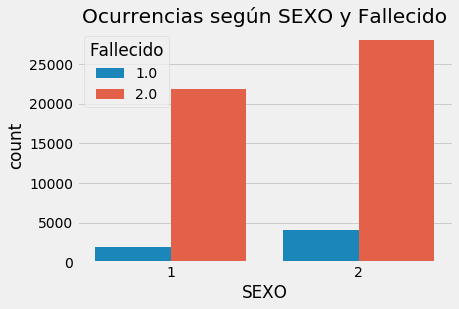

In [138]:
# Se pinta un countplot con los datos de fallecimiento por sexo
fig = sns.countplot(data=data_analisis, x='SEXO', hue='Fallecido')
plt.title('Ocurrencias según SEXO y Fallecido')

# Se añade una tabla de frecuencias
print('Frecuencias por SEXO')
print(data_analisis.groupby(["SEXO"]).size())
print('Frecuencias por SEXO y Fallecido')
crosstab = pd.crosstab(data_analisis['Fallecido'], data_analisis['SEXO'])
print(crosstab)

Se aprecia que existen considerablemente más casos de hombres que de mujeres en este dataset, ya que más hombres que mujeres han sido identificados como positivos en el test. También hay más casos de decesos en hombres que en mujeres, pero es necesario realizar un contraste de hipótesis para corroborar que dicha diferencia sea real o simplemente ruido de las distribuciones de probabilidad.

No obstante, si bien no existe el doble de hombres que de mujeres en el dataset, sí que existe el doble de fallecimientos de hombres que de mujeres. Esto puede inddicar que sí que existe una diferencia en las distribuciones, con lo que deben ser comparadas.

Para ello se plantean dos hipótesis, para las cuales se ha decidido utilizar un nivel de confianza del 95%:
* H<sub>0</sub>: La probabilidad de fallecimiento en hombres y mujeres es la misma (P(Fallecido=1)<sub>SEXO=2</sub> = P(Fallecido=1)<sub>SEXO=1</sub>).
* H<sub>1</sub>: la probabilidad de fallecimiento en hombres es distinta que en mujeres (P(Fallecido=1)<sub>SEXO=2</sub>  	&#8800;  P(Fallecido=1)<sub>SEXO=1</sub>).

Para la realización de este test, se debe evaluar si las distribuciones de probabilidad de fallecido para hombres y para mujeres son independientes o no. En este caso, es posible utilizar un test de contingencia de chi cuadrado, ya que permite conocer si las diferencias que están siendo observadas se deben a que ambas distribuciones son independientes, o son parate de la misma distribución.

In [139]:
# Se realiza el test de chi cuadrado con la crosstab creada antes
chi_value,p_value,degree_freedorm,_  = stats.chi2_contingency(crosstab)
print("Chi squere contingency p_value", p_value)

Chi squere contingency p_value 6.385333897073108e-67


En el test que se ha realizado, se obtiene un p valor considerablemente más bajo que el nivel de confianza requerido. Dado que este valor es inferior a 0.05, se debe rechazar la hipótesis nula en favor de la alternativa. Por lo tanto, se puede afirmar que, con los datos que se están viendo, la probabilidad de falleciemiento para hombres y mujeres es absolutamente distinta.

Finalmente, para determinar en qué medida es más probable morir de Coronavirus si se es hombre que si se es mujer, de acuerdo a los datos del conjunto, se calculan los odds ratio para la m

In [140]:
oddsratio, p_value = stats.fisher_exact(crosstab)
print(crosstab)
print(oddsratio, p_value)

SEXO           1      2
Fallecido              
1.0         1903   4037
2.0        21815  28020
0.6054704503625671 1.1534828783112591e-68


De lo que se obtiene que, una mujer tiene un 60% de probabilidad de morir con respecto a la probabilidad de muerte que tiene un varón frente al Coronavirus.

Se concluye, por tanto, que la probabilidad de fallecer debido a Coronavirus es distinta y más alta en hombres que en mujeres.

### <a id='5.3.3'> 5.3.3 Regresión logística: creación de un modelo simple de predicción de la probabilidad de fallecimiento de un paciente</a>

En este apartado se va a crear un modelo simple de regresión logística que permita conocer si es posible, dadas las observaciones del dataset, crear un clasificador simple que sea capaz de predecir la probabilidad de la fallecimiento de un paciente. En otras palabras, se busca conocer si el resto de variables más correlacionadas con ella, son capaces de explicar la varianza de la variable "Fallecido".

Para ello, se va a entrenar un modelo de regresión logística, el cual permite la clasificación binaria de variables basándose en variables numéricas y categóricas. Se van a utilizar las variables que se incluyen en este análisis, que son las que ya se ha demostrado que tienen una mayor correlación con la variable "Fallecido".

Se tratan todas ellas de variables categóricas, las cuales serán puestas en un rango más obvio para sklearn, donde 0 será considerado como 'no' y 1 como 'sí'. La variable de EDAD será estandarizada para eliminar su desviación.

Finalmente, se dividirá el dataset entre train y test, para que a la hora de medir el desempeño del clasificador, se haga con datos con los que no ha sido entrenado, y no se caiga en sesgo por ello.

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Se separan las features y las labels
X = data_analisis[['NEUMONIA','DIABETES','EDAD','HIPERTENSION','OTRO_CASO','RENAL_CRONICA','EPOC','SEXO']]
y = data_analisis[['Fallecido']]
 
# Se estandarizan los valores de EDAD para que estén entre  y 1
X['EDAD'] = StandardScaler().fit_transform(pd.DataFrame(X['EDAD']))
# Se ponen el resto de variables entre 0 y 1, siendo 1 el valor de sí y 0 no
X[['NEUMONIA','DIABETES','HIPERTENSION','OTRO_CASO','RENAL_CRONICA','EPOC','SEXO']] = X[['NEUMONIA','DIABETES','HIPERTENSION','OTRO_CASO','RENAL_CRONICA','EPOC','SEXO']].applymap(lambda x: int(x==1))

# Se hace un encoding homogéneo de las etiquetas para que estén en la misma escala que EDAD
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
# Se divide el dataset obtenido en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Una vez que se tienen los datasets listos es hora de entrenar el modelo. Para ello, se van a utilizar diferentes combinaciones de variables, añadiendo más variables al modelo en orden de correlación con 'Fallecido'. De esta manera se busca conocer qué conjunto de variables consigue crear un modelo que mejor prediga dicha variable, ya que es posible que añadir ciertas variables provoquen un empeoramiento en el modelo.

Se va a utilizar para medir el desempeño de cada uno de los modelos, los resultados obtenidos al predecir los valores con los datos de test, de manera que no se caiga en sesgo al evaluarlo.

In [142]:
variables = ['NEUMONIA','DIABETES','EDAD','HIPERTENSION','OTRO_CASO','RENAL_CRONICA','EPOC','SEXO']
variables_entrenamiento = []
model = LogisticRegression()
accuracies = []

for variable in variables:
    # Se añade una variable para el modelo
    variables_entrenamiento.append(variable)
    # Se entrena el modelo con las variables definidas en la iteración
    model.fit(X_train[variables_entrenamiento], y_train)
    # Se crean las predicciones sobre los datos de test y se calcula la precisión
    predicted = model.predict(X_test[variables_entrenamiento])
    accuracies.append(accuracy_score(y_test.flatten(),predicted))
    print("Variables:", variables_entrenamiento)
    print("Precisión:", accuracy_score(y_test.flatten(),predicted))

print("--------------------------------")
print("El mejor modelo tiene las variables {}, con precisión: {}".format(
                                                    variables[0:accuracies.index(max(accuracies))+1],
                                                    max(accuracies)))
print("--------------------------------")

Variables: ['NEUMONIA']
Precisión: 0.8913397805063566
Variables: ['NEUMONIA', 'DIABETES']
Precisión: 0.8913397805063566
Variables: ['NEUMONIA', 'DIABETES', 'EDAD']
Precisión: 0.8890579158969901
Variables: ['NEUMONIA', 'DIABETES', 'EDAD', 'HIPERTENSION']
Precisión: 0.8884602846897751
Variables: ['NEUMONIA', 'DIABETES', 'EDAD', 'HIPERTENSION', 'OTRO_CASO']
Precisión: 0.8884059545800282
Variables: ['NEUMONIA', 'DIABETES', 'EDAD', 'HIPERTENSION', 'OTRO_CASO', 'RENAL_CRONICA']
Precisión: 0.8889492556774965
Variables: ['NEUMONIA', 'DIABETES', 'EDAD', 'HIPERTENSION', 'OTRO_CASO', 'RENAL_CRONICA', 'EPOC']
Precisión: 0.8892209062262306
Variables: ['NEUMONIA', 'DIABETES', 'EDAD', 'HIPERTENSION', 'OTRO_CASO', 'RENAL_CRONICA', 'EPOC', 'SEXO']
Precisión: 0.8895468868847115
--------------------------------
El mejor modelo tiene las variables ['NEUMONIA'], con precisión: 0.8913397805063566
--------------------------------


Dado que la primera variable explica gran parte de la varianza de la variable objetivo 'Fallecido', el modelo no obtiene mejoras sustanciales a partir de la adición de variables sobre la variable 'NEUMONIA'. Sin embargo, el modelo, aunque poco, mejora.

De acuerdo a los resultados obtenidos, la variable 'SEXO', una vez incluidas el resto de variables en el modelo, aporta un nivel de sobreentrenamiento al modelo, y, por ello, se expulsa de las variables que generan el mejor modelo.

Por la tanto, se concluye que sí que es posible obtener un modelo de regresión logística simple que permita predecir, con accuracy de casi el 90%, la probabilidad de supervivencia de un paciente de Coronavirus que ha sido diagnosticado mediante un test como positivo, de acuerdo a otras características clínicas.

A modo de conlusión, se representan las puntuaciones obtenidas según se incrementó el número de variables en el modelo.

Text(0, 0.5, 'Precisión')

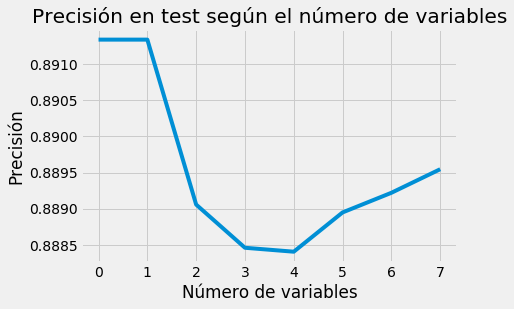

In [143]:
plt.plot(accuracies)
plt.title('Precisión en test según el número de variables')
plt.xlabel('Número de variables')
plt.ylabel('Precisión')

## <a id='5.4'> 5.4 Representación de los resultados a partir de tablas y gráficas</a>

Los resultados han sido representados en sus correspondientes apartados para justificar las conclusiones obtenidas.

## <a id='5.5'> 5.5 Conclusiones del análisis</a>

En este apartado se ha realizado un análisis estadístico inferencias sobre la probabilidad de la variable fallecimiento y su dependencia de otras variables del dataset utilizado en este documento. El objetivo del estudio ha sido determinar cómo afectan otras características clínicas de los pacientes de Coronavirus registrados en el dataset a la probabilidad de fallecimiento.

Para ello, se han realizado varios contrastes de hipótesis que corroboraron que, efectivamente, es posible explicar la varianza de la variable 'Fallecido' mediante el uso de otras variables. También se ha creado un modelo de regresión logística que ha permitido crear predicciones sobre la supervivencia o fallecimiento de dichos pacientes.

En primer lugar, se realizó una selección de las 7 variables más correladas con la variable 'Fallecido' para el análisis. 

Se analizó después la normalidad y la varianza de la variable 'EDAD', al ser esta la única variable numérica considerada. Se determinó que no está distribuida normalmente, y que la varianza de la distribución de de la edad de los pacientes muertos por Coronavirus es distinta a la de los que sobrevieron a la enfermedad.

También se realizó un análisis ANOVA de la probabilidad de fallecimiento de los pacientes según su grupo de edad, donde los pacientes fueron divididos en 4 grupos de edad según los cuartiles de la distribución. El resultado fue que, efectivamente, a medida que se avanza en edad, la probabilidad de fallecimiento crece considerablemente.

Después se realizó un estudio para dar respuesta a la pregunta de si mueren realmente más hombres que mujeres debido a la enfermedad. Se determinó que, efectivamente el ratio de muerte es mayor en hombres, y que, además, las mujeres tienen una probabilidad de muerte considerablemente inferior a la de los hombres.

Finalemente, se creó un modelo de regresión logística para dar respuesta a la pregunta sobre si es posible generar predicciones sobre el fallecimiento o supervivencia de los pacientes de coronavirus. Se meidió el desempeño del algoritmo mediante el uso de un conjunto de entrenamiento y otro de test, con diferentes conjuntos de variables y se obtuvo el mejor modelo posible. Se dermininó que sí que es posible generar predicciones sobre la probabilidad de fallecimiento de un paciente por Coronavirus una vez que ha sido diagnosticado como positivo, de acuerdo al resto de sus características clínicas.